In [1]:
import os
import sys
import torch
import numpy as np
import gpytorch
import tqdm
import matplotlib.pyplot as plt
from gpytorch import lazy, means, kernels
from sklearn.metrics import pairwise_distances

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

from src.models import VariationalCMEProcess
from src.likelihoods import CMEProcessLikelihood

### Generate mock volume data

In [2]:
def make_mock_column_data(size, depth, seed):
    torch.random.manual_seed(seed)
    # Create lat/lon/height vectors
    x = torch.arange(size).float()
    y = torch.arange(size).float()
    z = torch.arange(depth).float()
    
    # Create 2D view of observed aggregates
    grid = torch.stack(torch.meshgrid(x, y), dim=-1)
    aggregate = torch.sin((grid[..., 0].pow(2) + grid[..., 1].pow(2)).pow(0.5) * (0.05 * np.pi))
    aggregate.sub_(torch.sin((grid[..., 0] + grid[..., 1]) * (0.05 * np.pi)))
    aggregate.add_(torch.randn_like(grid[..., 0]).mul(0.05))
    
    # Create covariance matrices for 2D view and height
    plane_kernel = kernels.MaternKernel(nu=1.5)
    height_kernel = kernels.RBFKernel()
    plane_kernel.initialize(raw_lengthscale=2*torch.ones(1))
    height_kernel.initialize(raw_lengthscale=5*torch.ones(1))
    plane_covar = plane_kernel(grid.reshape(-1, 2))
    height_covar = height_kernel(torch.arange(0, 50).float())
    
    # Combine into covar of 3D volume and create distribution
    volume_mean = aggregate.unsqueeze(-1).repeat(1, 1, depth).flatten()
    volume_covar = lazy.KroneckerProductLazyTensor(plane_covar, height_covar)
    dist = gpytorch.distributions.MultivariateNormal(mean=volume_mean,
                                                     covariance_matrix=volume_covar)
    
    # Sample from distribution and return along with aggregate observations
    sample = dist.sample().reshape(size, size, depth).permute(2, 0, 1)
    return aggregate, sample, grid, z

In [3]:
groundtruth_aggregate, sample, grid, z = make_mock_column_data(size=50, depth=50, seed=42)
observed_aggregate = sample.mean(dim=0)

/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


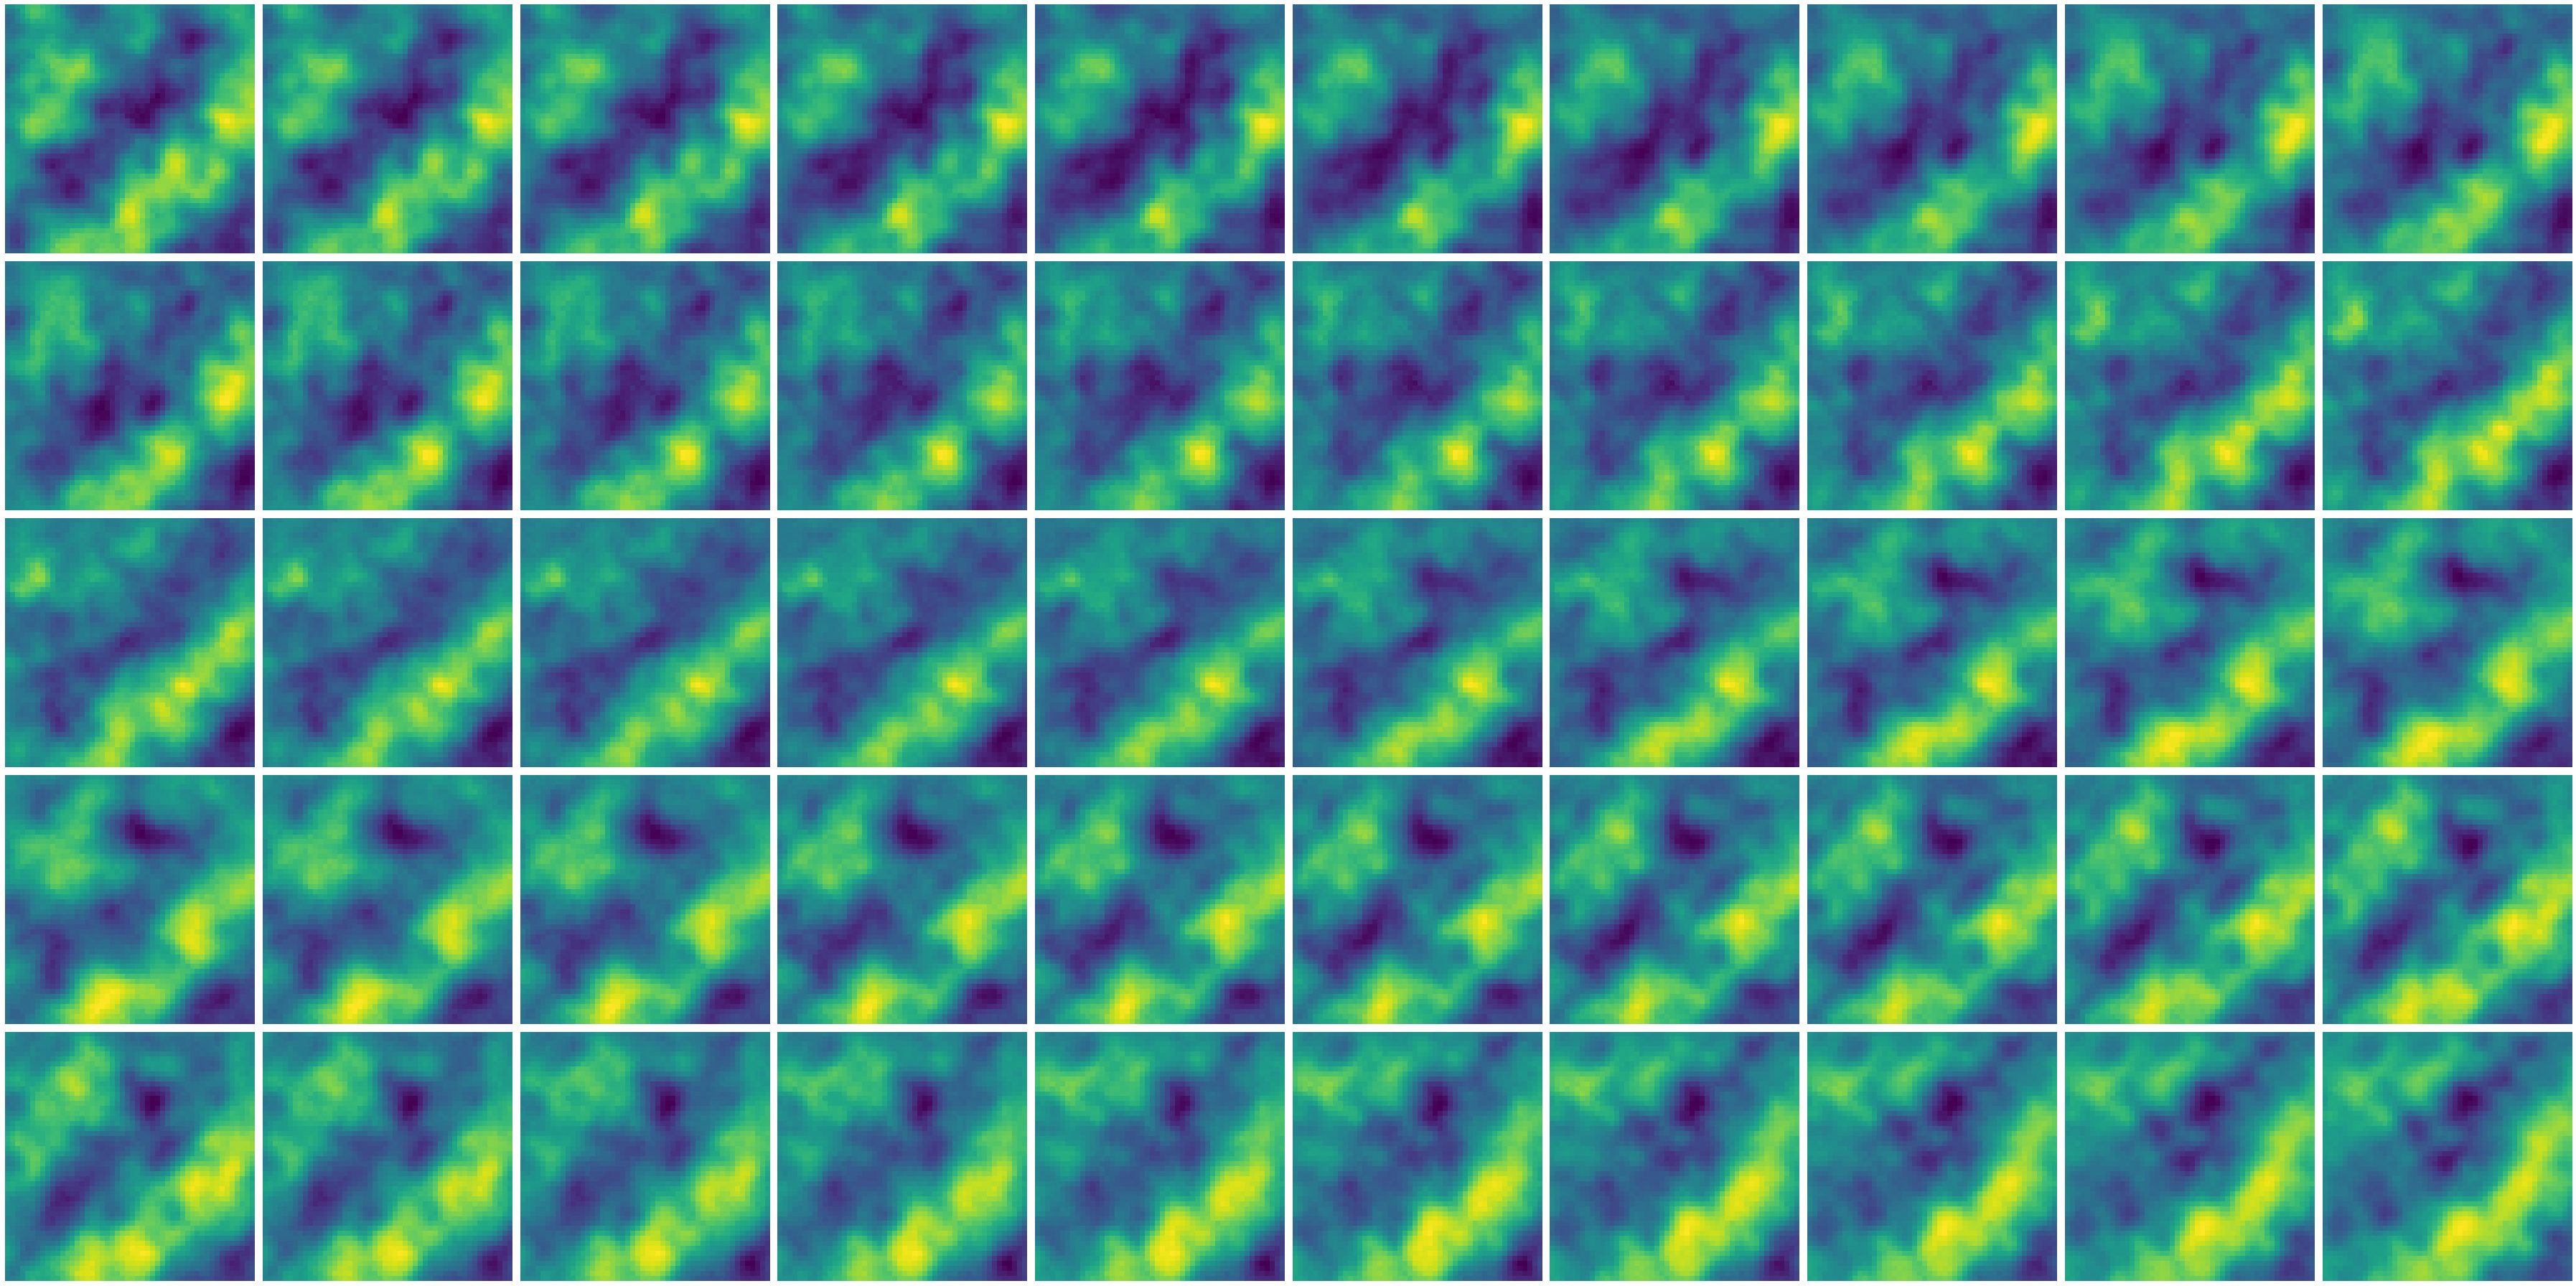

In [9]:
# Plot by height layer
fig, ax = plt.subplots(5, 10, figsize=(50, 25))
for i, layer in enumerate(sample):
    ax[i // 10, i % 10].imshow(layer)
    ax[i // 10, i % 10].axis('off')
plt.tight_layout()

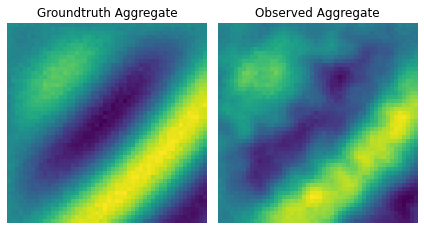

In [5]:
# Plot base mean 2D field used for generation against observed aggregate 2D field
fig, ax = plt.subplots(1, 2, figsize=(6, 4))

ax[0].imshow(groundtruth_aggregate)
ax[1].imshow(observed_aggregate)

ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Groundtruth Aggregate')
ax[1].set_title('Observed Aggregate')

plt.tight_layout()
plt.show()

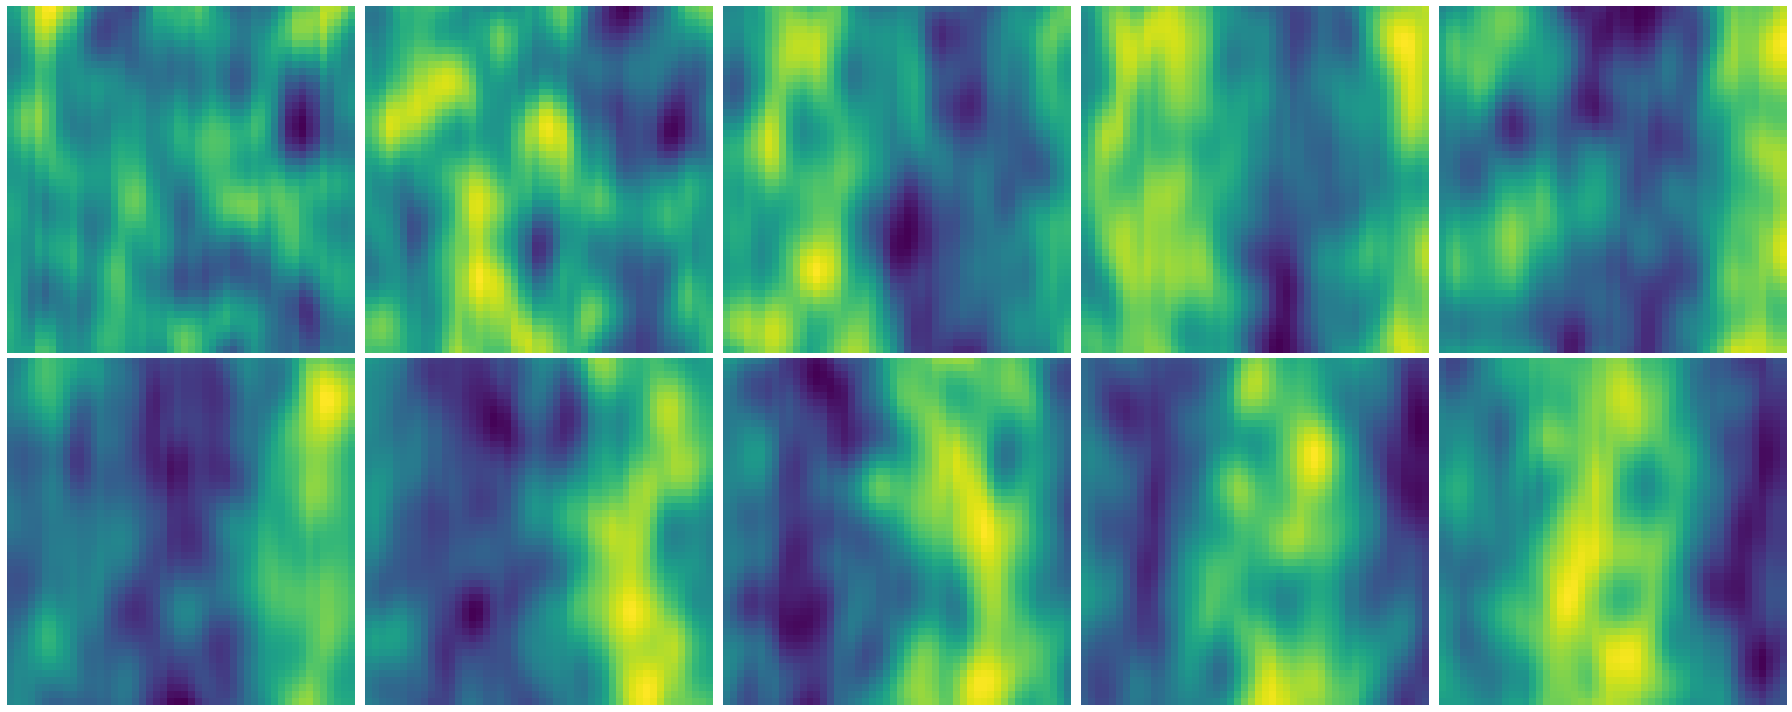

In [6]:
# Plot some height slices
fig, ax = plt.subplots(2, 5, figsize=(25, 10))

for i, vol_slice in enumerate(sample.permute(1, 2, 0)[::5]):
    ax[i // 5, i % 5].imshow(vol_slice.T)
    ax[i // 5, i % 5].axis('off')

plt.tight_layout()

## Format into dataset

In [10]:
# Standardize lat/lon and height
grid = (grid - grid.mean(dim=(0, 1))) / grid.std(dim=(0, 1))
z = (z - z.mean()) / z.std()

# Create additional height feature correlated to prediction target
feature = sample.pow(2) + torch.sin(sample)
feature = (feature - feature.mean()) / feature.std()

In [11]:
# Individuals = inputs to desaggregation function = (lat, lon, height, feature)
# Bags = columns lat and lon
individuals = z.unsqueeze(0).repeat(50**2, 1).unsqueeze(-1)
bags = grid.reshape(-1, 2)
individuals = torch.cat([bags.unsqueeze(1).repeat(1, len(z), 1), 
                         individuals,
                         feature.permute(1, 2, 0).reshape(-1, 50, 1)], dim=-1)
extended_bags = bags.unsqueeze(1).repeat(1, 50, 1)

# Observed aggregate targets = mean aggregate over height columns
aggregate_targets = observed_aggregate.flatten()

# Inducing point for variational derivation
inducing_points = individuals.reshape(-1, 4)[::400]

print("Individuals : ", individuals.shape)
print("Bags values : ", bags.shape)
print("Aggregate targets : ", aggregate_targets.shape)
print("Extended bags values : ", extended_bags.shape)
print("Inducing points : ", inducing_points.shape)

def batch_iterator(batch_size):
    rdm_indices = torch.randperm(bags.size(0))
    for idx in rdm_indices.split(batch_size):
        x = individuals[idx].reshape(-1, 4)
        y = bags[idx]
        extended_y = extended_bags[idx].reshape(-1, 2)
        tgt = aggregate_targets[idx]
        yield x, y, extended_y, tgt

Individuals :  torch.Size([2500, 50, 4])
Bags values :  torch.Size([2500, 2])
Aggregate targets :  torch.Size([2500])
Extended bags values :  torch.Size([2500, 50, 2])
Inducing points :  torch.Size([313, 4])


### Compute median distance between feature for lengthscale intializations

In [13]:
foo = individuals.reshape(-1, 4)
rdm_idx = torch.randperm(len(foo))[:5000]

lat_scale = np.median(pairwise_distances(foo[rdm_idx, 0].reshape(-1, 1).numpy()))
lon_scale = np.median(pairwise_distances(foo[rdm_idx, 1].reshape(-1, 1).numpy()))
height_scale = np.median(pairwise_distances(foo[rdm_idx, 2].reshape(-1, 1).numpy()))
feature_scale = np.median(pairwise_distances(foo[rdm_idx, 3].reshape(-1, 1).numpy()))

print("Latitude lengthscale : ", lat_scale)
print("Longitude lengthscale : ", lon_scale)
print("Height lengthscale : ", height_scale)
print("Feature lengthscale : ", feature_scale)

Latitude lengthscale :  1.0392305
Longitude lengthscale :  1.0392305
Height lengthscale :  1.0289915
Feature lengthscale :  0.70428896


## Define covariance modules

In [18]:
inv_softplus = lambda x, n: torch.log(torch.exp(x * torch.ones(n)) - 1)

individuals_mean = means.ZeroMean()

# Individuals kernel = k(lat,lon) * k(height) + k(feature)
base_plane_kernel = kernels.MaternKernel(nu=1.5, ard_num_dims=2, active_dims=[0, 1])
base_plane_kernel.initialize(raw_lengthscale=inv_softplus(x=1, n=2))

base_height_kernel = kernels.MaternKernel(nu=1.5, active_dims=[2])
base_height_kernel.initialize(raw_lengthscale=inv_softplus(x=1, n=1))

base_feat_kernel = kernels.RBFKernel(active_dims=[3])
base_feat_kernel.initialize(raw_lengthscale=inv_softplus(x=0.7, n=1))

individuals_plane_kernel = kernels.ScaleKernel(base_plane_kernel)
individuals_height_kernel = kernels.ScaleKernel(base_height_kernel)
individuals_feat_kernel = kernels.ScaleKernel(base_feat_kernel)

individuals_kernel = individuals_plane_kernel * individuals_height_kernel + individuals_feat_kernel

# Bag kernel = k(lat,lon)
base_bag_kernel = kernels.MaternKernel(nu=1.5, ard_num_dims=2)
base_bag_kernel.initialize(raw_lengthscale=inv_softplus(x=1, n=2))
bag_kernel = kernels.ScaleKernel(base_bag_kernel)

## Create model

In [19]:
# Instantiate model
model = VariationalCMEProcess(inducing_points=inducing_points,
                              individuals_mean=individuals_mean, 
                              individuals_kernel=individuals_kernel,
                              bag_kernel=bag_kernel,
                              lbda=1e-3)

likelihood = CMEProcessLikelihood()

### Define some utilities to visualize predictions

In [20]:
def reconstruct_full_img(gs, individuals):
    model.eval()
    likelihood.eval()
    cube = individuals.reshape(50, 50, 50, -1)
    row_wise_pred = []
    for i in tqdm.tqdm(range(0, cube.shape[0], gs)):
        col_wise_pred = []
        for j in range(0, cube.shape[1], gs):
            x_test = cube[i:i+gs, j:j+gs]
            block_size = x_test.shape[:-1]
            with torch.no_grad():
                individuals_posterior = model(x_test.reshape(-1, 4))
            col_wise_pred.append(individuals_posterior.mean.reshape(*block_size))
        row_tensor = torch.cat(col_wise_pred, dim=1)
        row_wise_pred.append(row_tensor)
    full_tensor = torch.cat(row_wise_pred, dim=0)
    model.train()
    likelihood.train()
    return full_tensor

def save_img(epoch, tensor):
    fig, ax = plt.subplots(5, 10, figsize=(24, 12))
    for i, layer in enumerate(tensor.permute(2, 0, 1)):
        ax[i // 10, i % 10].imshow(layer)
        ax[i // 10, i % 10].axis('off')
    plt.tight_layout()
    plt.savefig(f"mock_aodisaggregation/epoch_{epoch}.png")
    plt.close()

## Fit MLE of hyperparameters

In [21]:
torch.random.manual_seed(52)
epochs = 80
batch_size = 32

model.train()
likelihood.train()

parameters = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params=parameters, lr=0.01)

elbo = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(aggregate_targets))

epochs_iter = tqdm.notebook.tqdm(range(epochs), desc="Epoch")
for epoch in epochs_iter:
    batch_iter = tqdm.notebook.tqdm(batch_iterator(batch_size), desc="Batch", 
                                    total=len(bags) // batch_size)
    for x, y, extended_y, tgt in batch_iter:
        optimizer.zero_grad()
        q = model(x)
        buffer = model.get_elbo_computation_parameters(bags_values=y,
                                                       extended_bags_values=extended_y)
        root_inv_extended_bags_covar, bags_to_extended_bags_covar = buffer
        loss = -elbo(variational_dist_f=q, 
                     target=tgt,
                     root_inv_extended_bags_covar=root_inv_extended_bags_covar,
                     bags_to_extended_bags_covar=bags_to_extended_bags_covar)

        loss.backward()
        optimizer.step()
        lengthscales = model.individuals_kernel.kernels[0].kernels[0].base_kernel.lengthscale[0].detach()
        lz = model.individuals_kernel.kernels[0].kernels[1].base_kernel.lengthscale[0].detach()
        batch_iter.set_postfix(loss=loss.item(),
                               n=likelihood.noise.item(),
                               l1=lengthscales[0].item(),
                               l2=lengthscales[1].item(),
                               lz=lz[0].item())
    full_tensor = reconstruct_full_img(gs=2, individuals=individuals)
    save_img(int(epoch), full_tensor)

  0%|          | 0/25 [00:00<?, ?it/s]

/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.40s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:38<00:00,  1.56s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:35<00:00,  1.40s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

 32%|███▏      | 8/25 [00:11<00:23,  1.39s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(55,55) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
 76%|███████▌  | 19/25 [00:26<00:08,  1.37s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(57,57) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(60,60) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(56,56) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error o

  0%|          | 0/25 [00:00<?, ?it/s]

 72%|███████▏  | 18/25 [00:32<00:12,  1.82s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(67,67) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
100%|██████████| 25/25 [00:45<00:00,  1.83s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:46<00:00,  1.85s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:46<00:00,  1.88s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:46<00:00,  1.85s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

 76%|███████▌  | 19/25 [00:35<00:11,  1.85s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(69,69) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
100%|██████████| 25/25 [00:47<00:00,  1.90s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:08<00:00,  2.76s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:42<00:00,  1.69s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:45<00:00,  1.83s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(68,68) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
 44%|████▍     | 11/25 [00:21<00:30,  2.17s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(74,74) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
 64%|██████▍   | 16/25 [00:36<00:21,  2.38s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decompositio

  0%|          | 0/25 [00:00<?, ?it/s]

 76%|███████▌  | 19/25 [00:37<00:12,  2.01s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(70,70) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
100%|██████████| 25/25 [00:48<00:00,  1.95s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:45<00:00,  1.81s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:45<00:00,  1.81s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:49<00:00,  1.98s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:49<00:00,  1.96s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:47<00:00,  1.89s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:47<00:00,  1.91s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:41<00:00,  1.67s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:51<00:00,  2.08s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:41<00:00,  1.67s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

 80%|████████  | 20/25 [00:35<00:08,  1.74s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(72,72) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
100%|██████████| 25/25 [00:44<00:00,  1.77s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:42<00:00,  1.71s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:07<00:00,  2.69s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:44<00:00,  1.79s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:48<00:00,  1.94s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:47<00:00,  1.90s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:45<00:00,  1.81s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:44<00:00,  1.79s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

 24%|██▍       | 6/25 [00:10<00:34,  1.80s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(49,49) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
 64%|██████▍   | 16/25 [00:28<00:16,  1.79s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(50,50) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
100%|██████████| 25/25 [00:45<00:00,  1.80s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:44<00:00,  1.80s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:42<00:00,  1.70s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:50<00:00,  2.04s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:36<00:00,  1.47s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

 12%|█▏        | 3/25 [00:04<00:34,  1.57s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(48,48) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
100%|██████████| 25/25 [00:37<00:00,  1.51s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(109,109) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:50<00:00,  2.03s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:44<00:00,  1.79s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:56<00:00,  2.28s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:03<00:00,  2.54s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:44<00:00,  1.77s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:49<00:00,  2.00s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:46<00:00,  1.85s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:47<00:00,  1.89s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:57<00:00,  2.32s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:53<00:00,  2.14s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(159,159) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
  0%|          | 0/25 [00:00<?, ?it/s]

 28%|██▊       | 7/25 [00:11<00:31,  1.75s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(47,47) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
 48%|████▊     | 12/25 [00:20<00:22,  1.70s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(38,38) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
100%|██████████| 25/25 [00:43<00:00,  1.73s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:43<00:00,  1.75s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(45,45) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(46,46) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error o

  0%|          | 0/25 [00:00<?, ?it/s]

/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(36,36) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(32,32) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error o

  0%|          | 0/25 [00:00<?, ?it/s]

 64%|██████▍   | 16/25 [00:32<00:25,  2.81s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(52,52) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
100%|██████████| 25/25 [00:56<00:00,  2.24s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:47<00:00,  1.90s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:43<00:00,  1.75s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:46<00:00,  1.88s/it]


  0%|          | 0/25 [00:00<?, ?it/s]

 40%|████      | 10/25 [00:16<00:25,  1.70s/it]/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/lazy/lazy_tensor.py:1354: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(29,29) is zero, singular U.. Using RootDecomposition.
  warnings.warn(
100%|██████████| 25/25 [00:43<00:00,  1.72s/it]


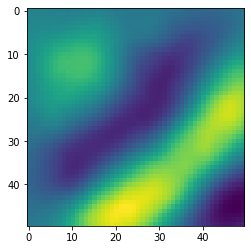

In [40]:
plt.imshow(full_tensor.mean(dim=-1))